<a href="https://colab.research.google.com/github/Carhuacusma/SI404_IA/blob/main/AG_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maximización de la esperanza de vida a partir de algoritmos genéticos

### Miembros:
* Rafael Andrés Andrade Rodríguez - u201812443
* Dante Moreno Carhuacusma - u201818067

### Asesor:
* Hugo David Calderón Vilca

### Universidad Peruana de Ciencias Aplicadas.
Lima, Perú

# Desarrollo de la Solución

In [ ]:
import random
import numpy as np
import pandas as pd
import ipywidgets as widgets
from matplotlib import pyplot as plt

Durante el desarrollo de la solución, clasificamos a las personas según diferentes métricas. El diccionario de dichas categorías es:

Actividad | Desripción | Valor
--- | --- | ---
Sedentario | Muy poco o nulo ejercicio | 0
Livianamente activo | Practica ejercicio liviano de 1 a 3 días por semana | 1
Moderadamente activo | Ejercicio moderado o deporte de 3 a 5 días a la semana | 2
Muy Activo | Ejercicios y deportes fuertes de 6 a 7 días a la semana | 3
Extra Activo | Ejercicios muy fuertes y un trabajo físico | 4

## Individuo:


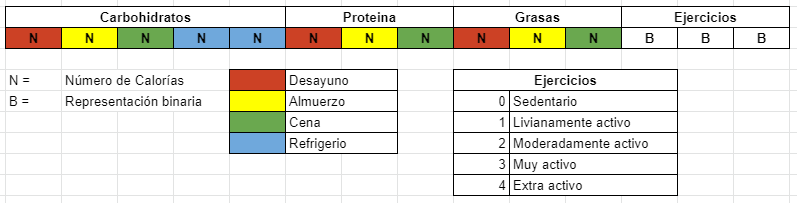

In [ ]:
class estado:
  #... CONSTRUCTOR
  def __init__(self):
    self.arreglo = [random.randint(0,500) for i in range(11)]
    for i in range(3):
      self.arreglo.append(random.randint(0,1))
  
  #... Funciones auxiliares para la heurística
  
  #..... 1. Calorías
  def get_calorias(self):
    return sum(self.arreglo[:11])

  #..... 2. Ejercicios
  def get_ejercicios(self):
    a = list(self.arreglo[11:])
    res = 0
    for i in range(len(a)):
      res += a[i] * pow(2, 2 - i)
    if res > 4:
      return 4
    return res

  
  #... MUTACIÓN
  def mutar(self):
    r = random.randint(0,100)/100
    if r < 0.20:
      k = random.randint(0,11)
      self.arreglo[k] = random.randint(0,500)
      k = random.randint(12,13)
      self.arreglo[k] = random.randint(0,1)

  #... CRUCE
  def cruce(self, otro):
    def crear_hijos(padres):
      n = len(padres[0])
      if n != len(padres[1]): #... Si son de diferente len(), termina
        print("ERROR en Cruce -> crear_hijos(). Diferente len() de padres")
        return False
      j = random.randint(int(n/2),n)
      aux = [(0,1),(1,0)]
      hijos = []
      for i in aux:
        p1 = padres[i[0]][:j]
        p2 = padres[i[1]][j:]
        hijo = p1 + p2
        hijos.append(hijo)
      return hijos
    
    dieta_1 = self.arreglo[:11]
    dieta_2 = otro.arreglo[:11]
    ejerc_1 = self.arreglo[11:]
    ejerc_2 = otro.arreglo[11:]
    hijos_dieta = crear_hijos([dieta_1, dieta_2])
    hijos_ejerc = crear_hijos([ejerc_1, ejerc_2])
    hijos = [estado() for i in range(2)]
    for i in range(2):
      hijos[i].arreglo = hijos_dieta[i] + hijos_ejerc[i]
    return hijos
  # end

#... EJEMPLO
E1 = estado()
E2 = estado()
print(E1.arreglo)
print(E2.arreglo)
hijos = E1.cruce(E2)
for h in hijos:
  print(">>", h.arreglo)

[28, 431, 196, 225, 187, 13, 385, 103, 32, 233, 80, 1, 0, 0]
[356, 426, 401, 43, 371, 26, 18, 423, 99, 296, 383, 0, 0, 1]
>> [28, 431, 196, 225, 187, 13, 385, 423, 99, 296, 383, 1, 0, 0]
>> [356, 426, 401, 43, 371, 26, 18, 103, 32, 233, 80, 0, 0, 1]


## Heurística:

### 1. Metabolismo Basal

El cálculo de $BMR$ (metabolismo basal), depende del:
- $sexo$, hombre o mujer
- $peso$, en kilogramos
- $estatura$, en centímetros
- $edad$, en años

de la persona.
> [Mateusz Mucha y Aleksandra Zając](https://www.omnicalculator.com/health/bmr-harris-benedict-equation) simplifican la ecuación de Harris-Benedict como:
* $BMR = (10 \times Peso) + (6.25 \times Estatura) - (5 \times Edad)+s$
* Para **hombres**, $s=+5$
* Para **mujeres**, $s=-161$

Consideramos las variables personales como constantes para el desarrollo de la función heurística $h(x)$

### 2. TDEE: Total de gasto de energía

El $TDEE$ determina cuántas kilocalorías necesita una persona diariamente.
El cálculo varía según el nivel de actividad.
- **Sedentario** (Muy poco o nulo ejercicio): $TDEE = BMR \times 1.2$
- **Activo Livianamente** (Ejercicio liviano de 1 a 3 días por semana): $TDEE = BMR \times 1.375$
- **Moderadamente activo** (Ejercicio moderado o deporte de 3 a 5 días a la semana): $TDEE = BMR \times 1.55$
- **Muy Activo** (Ejercicios y deportes fuertes de 6 a 7 días a la semana): $TDEE = BMR \times 1.725$
- **Extra Activo** (Ejercicios muy fuertes y un trabajo físico): $TDEE = BMR \times 1.9$

### 3. Información del usuario e IMC.

Utilizando la información de [CDC (Centros para el Control y Detección de Enfermedades)](https://www.cdc.gov/healthyweight/spanish/assessing/index.html), podemos clasificar a la persona según su IMC. De esta manera, definimos los objetivos para la persona.

IMC | Descripción | Código
--- | --- | ---
Inferior a 18.5 | Bajo Peso | 0
Entre 18.5 y 24.9 | Peso saludable | 1
Entre 25.0 y 29.9 | Sobrepeso | 2
30.0 o superior | Obesidad | 3

Dado que $IMC = \frac{peso}{estatura^2}$; donde el $peso$ está expresado en kilogramos, y la $estatura$ en metros.

In [ ]:
class informacion:
  def __init__(self, sexo, peso, estatura, edad, actividad):
    self.sexo = sexo
    self.peso = peso
    self.estatura = estatura
    self.edad = edad
    self.actividad = actividad
    #... MÉTRICAS
    self.IMC = self.peso / pow(self.estatura/100, 2) #.... IMC (índice de masa corporal)
    self.BMR = (10 * self.peso) + (6.25 * self.estatura) - (5 * self.edad) #... BMR (Metabolismo Basal)
    if self.sexo == "HOMBRE":
      self.BMR = self.BMR + 5
    elif self.sexo == "MUJER":
      self.BMR = self.BMR - 161
    else:
      print("ERROR: Sexo no definido")
    self.TDEE = self.BMR * (1.2 + self.actividad * 0.175) #... TDEE (Total Daily Energy Expenditure)
    self.objetivo = None #... Definir 'Objetivo'
    if self.IMC < 18.5:
      self.objetivo = 1 # Subir
    elif self.IMC < 25:
      self.objetivo = 0 # Peso Saludable, debe mantener
    elif self.IMC < 30:
      self.objetivo = -1 # Debe bajar, tiene Sobrepeso
    else:
      self.objetivo = -2 # Debe bajar mucho peso, tiene Obesidad

  def __str__(self):
    return "%s de %s años, %s kg, y %s cm \n >> IMC: %s \n >> BMR: %s \n >> TDEE: %s"%(self.sexo, self.edad, self.peso, self.estatura, self.IMC, self.BMR, self.TDEE)


### 4. Función personalizada

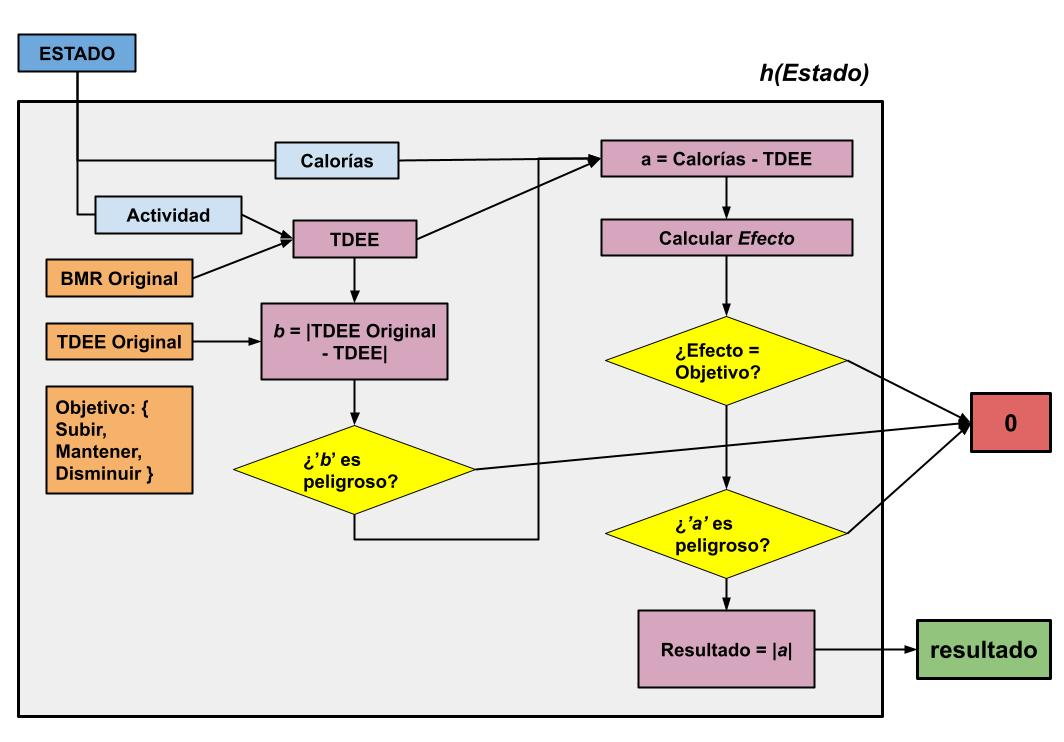

In [ ]:
def crear_h(info):
  BMR_original = info.BMR #...... 1. BMR ORIGINAL
  TDEE_original = info.TDEE #.... 2. TDEE ORIGINAL
  #Objetivo_original = info.objetivo #... 3. DEFINIR OBJETIVO
  #.... 4. h(estado)
  def h(x):
    """
    print(BMR_original)
    print(TDEE_original)
    print(info.objetivo)
    """
    #print(Objetivo_original) Por alguna razón no lo guarda? xd
    #==== Extraer Información del 'Estado' ====
    calorias = x.get_calorias()
    actividad = x.get_ejercicios()
    #==== TDEE según este estado ====
    TDEE = BMR_original * (1.2 + actividad * 0.175)
    #==== ¿El Cambio de Métricas es muy brusco? ====
    aux = abs(TDEE - TDEE_original)
    if aux > (BMR_original * 0.35): #... 2 unidades de diferencia en 'actividad' (2 x 0.175 = 0.35)
      """print("Es Peligroso (b)")"""
      return 0
    #==== Calorías Consumidas - Necesarias ====
    aux = calorias - TDEE #...Recibo C calorias, necesito TDEE calorias
    efecto = 0 #..............Efecto
    if info.objetivo == -2:
      info.objetivo = -1 #.... Homogeneizar
    if aux < -500:
      efecto = -1 # Si a < 0; Consumo menos de lo que necesito; Bajo de Peso
    elif aux > 500:
      efecto = 1 # Si a > 1; Consumo más de lo que necesito; Subo de Peso
    #==== Si no es el efecto deseado, salir ====
    if efecto != info.objetivo:
      """
      print("El efecto no es el deseado:", efecto)
      print("Se quiere:", info.objetivo)
      """
      return 0
    #==== Si es un cambio brusco, salir (Debe consumir mínimo su BMR) ====
    if abs(aux) > BMR_original:
      """print("Es Peligroso (a)")"""
      return 0 
    return abs(aux)

  return h

# ===== PRUEBAS ====
Informacion = informacion(sexo = "HOMBRE", peso = 98.5, estatura = 177, edad = 19, actividad = 1)
print(Informacion)
#print("IMC:", Informacion.IMC)
print("Objetivo:", Informacion.objetivo)
h = crear_h(Informacion)
print("===========================")
print(E1.arreglo)
print(h(E1))

HOMBRE de 19 años, 98.5 kg, y 177 cm 
 >> IMC: 31.440518369561744 
 >> BMR: 2001.25 
 >> TDEE: 2751.71875
Objetivo: -2
[28, 431, 196, 225, 187, 13, 385, 103, 32, 233, 80, 1, 0, 0]
0


## Algoritmo Genético

In [ ]:
class AG():
  def __init__(self, h, n = 8):
    #... 1. Generar Población Original de Estados Aleatorios
    self.n = n
    self.poblacion = [estado() for i in range(n)]
    self.h = h #... Define Heurística
  
  def hallar_mejor(self):
    # Ordena y retorna TUPLA (mejor estado,mejor h(x))
    self.poblacion = sorted(self.poblacion, key = self.h)
    return (self.poblacion[-1], self.h(self.poblacion[-1]))

  def algoritmo_genetico(self, comparar = False, deseado = np.inf):
    #... 2: Elegir los mejores
    (mejor, h_m) = self.hallar_mejor() #... 2.1. Ordena y halla el mejor hasta ahora
    if comparar:
      if h_m > deseado:
        return (mejor, h_m) #¿Es un h(x) aceptable?, Entonces ACABA.
    for _ in range(2):
      self.poblacion.pop(0) #................................. 2.2. Eliminará a los 2 peores
    nuevos_hijos = self.poblacion[-1].cruce(self.poblacion[-2]) #... 2.3. Cruce entre los 2 mejores
    #... 3: Mutacion
    for p in nuevos_hijos:
      p.mutar()
      self.poblacion.append(p) #... Agregar los hijos a la población
    return None
  
  # ===== Automatizar
  def automatico(self, deseado = None, iteraciones = None):
    encontrado = False
    iterar = False
    comparar = False
    i = 0
    if iteraciones:
      iterar = True
    if deseado:
      comparar = True
    while not encontrado:
      res = self.algoritmo_genetico(comparar, deseado)
      if iterar:
        i += 1
        if i == iteraciones:
          # Si se quiere max iteraciones, entonces terminar en el tope
          return self.hallar_mejor()
      if comparar and res:
        # Si se quiere comparar y res NO es Vacío.
        return res

modelo = AG(h,4)
print("Poblacion Original")
for p in modelo.poblacion:
  print(p.arreglo)
print("Iterar 50 veces")
modelo.automatico(iteraciones=50)
for p in modelo.poblacion:
  print(p.arreglo)
  print(h(p))
print("Conseguir 2500")
res = modelo.automatico(deseado=2500, iteraciones = 100)
print(res[1])
print(res[0].arreglo)

Poblacion Original
[361, 33, 490, 287, 493, 376, 251, 293, 273, 86, 248, 1, 1, 1]
[433, 23, 298, 102, 414, 307, 167, 173, 123, 348, 56, 0, 1, 0]
[186, 333, 207, 328, 93, 293, 246, 420, 189, 184, 256, 1, 1, 1]
[483, 414, 426, 69, 156, 84, 136, 465, 57, 235, 376, 1, 1, 1]
Iterar 50 veces
[391, 23, 298, 102, 414, 307, 167, 173, 123, 348, 28, 0, 1, 1]
1078.1562499999995
[391, 23, 298, 102, 414, 307, 167, 173, 123, 348, 28, 0, 1, 1]
1078.1562499999995
[105, 23, 298, 102, 414, 307, 167, 173, 123, 348, 28, 0, 1, 1]
1364.1562499999995
[105, 23, 298, 102, 414, 307, 167, 173, 123, 348, 28, 0, 1, 1]
1364.1562499999995
Conseguir 2500
1673.1562499999995
[78, 14, 298, 102, 335, 307, 86, 60, 123, 348, 28, 0, 1, 1]


## Interpretador

### Data

Extraemos data nutricional de alimentos de [Kaggle](https://www.kaggle.com/niharika41298/nutrition-details-for-most-common-foods). Este dataset almacena las comidas más comunes, sus categorías (lácteos, vegetales, carnes, etc.) y sus valores nutricionales.

In [ ]:
nutrientes = pd.read_csv("nutrients_csvfile.csv")
print("Dataset de %s filas"%(len(nutrientes)))
print(nutrientes.dtypes)
nutrientes.head()

Dataset de 335 filas
Food        object
Measure     object
Grams       object
Calories    object
Protein     object
Fat         object
Sat.Fat     object
Fiber       object
Carbs       object
Category    object
dtype: object


,Food,Measure,Grams,Calories,Protein,Fat,Sat.Fat,Fiber,Carbs,Category
0,Cows' milk,1 qt.,976,660,32,40,36,0,48,Dairy products
1,Milk skim,1 qt.,984,360,36,t,t,0,52,Dairy products
2,Buttermilk,1 cup,246,127,9,5,4,0,13,Dairy products
3,"Evaporated, undiluted",1 cup,252,345,16,20,18,0,24,Dairy products
4,Fortified milk,6 cups,"1,419","1,373",89,42,23,1.4,119,Dairy products


#### Preprocesamiento

1. Según el diccionario de datos en la página original, los valores '$t$' representan cantidades minúsculas. Por esto, las reemplazamos con 0.
2. Debido a la presencia de los valores $t$, las columnas 2 a 8 (Gramos a Carbohidratos) son de tipo "Objeto".

In [ ]:
def preprocesamiento(df):
  df = df.replace("t",0)
  df = df.replace("t'",0)
  columnas = df.columns
  for i in range(2,9):
    df[columnas[i]] = pd.to_numeric(df[columnas[i]], errors='coerce')
  print(df.dtypes)
  return df

nutrientes = preprocesamiento(nutrientes)

Food         object
Measure      object
Grams       float64
Calories    float64
Protein       int64
Fat           int64
Sat.Fat     float64
Fiber       float64
Carbs       float64
Category     object
dtype: object


#### Agregar Proporciones

In [ ]:
pd.unique(nutrientes["Protein"])
sum(nutrientes["Protein"])

2872

In [ ]:
c = "Fat"
for i in range(len(nutrientes)):
  if pd.isna(nutrientes[c][i]):
    print("NULL en ", i)

In [ ]:
def normalizar(arr):
  t = sum(arr)
  f_r = []
  for a in arr:
    f_r.append(round(a / t, 1))
  return f_r

n = len(nutrientes)
col_objs = ["Carbs", "Protein", "Fat"] # "Sat.Fat" después
p_carbs = []
p_protein = []
p_fat = []
for i in range(n):
  aux = True
  for c in col_objs:
    #if pd.isna(nutrientes.iloc[i,c]):
    if pd.isna(nutrientes[c][i]):
      aux = False
  #--- ¿Se puede sin miedo a los NaN?
  if aux:
    aux = [nutrientes[c][i] for c in col_objs]
    if not pd.isna(nutrientes["Sat.Fat"][i]):
      aux[2] = aux[2] + nutrientes["Sat.Fat"][i] # Suma Grasas Saturadas a Grasas si se lo permiten :p
    aux = normalizar(aux)
    p_carbs.append(aux[0])
    p_protein.append(aux[1])
    p_protein.append(aux[2])
    if i > 330:
      print(i)
  #-- parte de for
print(len(p_protein))
print(len(nutrientes))
#aux = nutrientes.assign(p_protein = p_protein)
#aux.head()

331
332
333
334
670
335


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


### Recibir estado $x$

In [ ]:
def interpretar(x, data):
  # ============================= EJERCICIOS ============================= 
  actividad = ["Sedentario (Muy poco o nulo ejercicio)", 
              "Activo Livianamente (Ejercicio liviano de 1 a 3 días por semana)",
              "Moderadamente activo (Ejercicio moderado o deporte de 3 a 5 días a la semana)",
              "Muy Activo (Ejercicios y deportes fuertes de 6 a 7 días a la semana)",
              "Extra Activo (Ejercicios y trabajo físico)"]
  print("Ud. debería ser: ", actividad[x.get_ejercicios()])
  # ============================= DIETA =============================
  carbohidratos = x.arreglo[:5]
  proteinas = x.arreglo[5:8]
  grasas = x.arreglo[8:11]
  nombres_nutrientes = ["Carbohidratos", "Proteínas", "Grasas"]
  proporcion_nutrientes = []
  comidas = [[] for _ in range(4)]
  nombres_comidas = ["Desayuno", "Almuerzo", "Cena", "Refrigerios"]
  for i in range(3):
    comidas[i].append(carbohidratos[i])
    comidas[i].append(proteinas[i])
    comidas[i].append(grasas[i])
    p_nutrientes = normalizar(comidas[i])
    proporcion_nutrientes.append(p_nutrientes)
  comidas[3] = carbohidratos[3:]
  print("En un día, tus comidas deberían ser:")
  for i in range(4):
    aux = ">> %s de %s kcal"%(nombres_comidas[i], sum(comidas[i]))
    print(aux)
    if i < 3:
      for j in range(3):
        p_nutrientes = proporcion_nutrientes[i]
        print("\t %s: %s de 1"%(nombres_nutrientes[j], p_nutrientes[j]))
E1 = estado()
print(E1.arreglo)
interpretar(E1, 0)

[315, 287, 142, 321, 196, 406, 111, 102, 453, 410, 48, 1, 0, 0]
Ud. debería ser:  Extra Activo (Ejercicios y trabajo físico)
En un día, tus comidas deberían ser:
>> Desayuno de 1174 kcal
	 Carbohidratos: 0.3 de 1
	 Proteínas: 0.3 de 1
	 Grasas: 0.4 de 1
>> Almuerzo de 808 kcal
	 Carbohidratos: 0.4 de 1
	 Proteínas: 0.1 de 1
	 Grasas: 0.5 de 1
>> Cena de 292 kcal
	 Carbohidratos: 0.5 de 1
	 Proteínas: 0.3 de 1
	 Grasas: 0.2 de 1
>> Refrigerios de 517 kcal


## Función Automatizada

Para automatizar el proceso, desarrollamos una función que obtenga como datos de entrada:
- Información del Usuario
- Número máximo de iteraciones o un Valor de $h(x)$ deseado

El proceso interno consiste en:
1. Personalizar $h(x)$ a partir de $Informacion$
2. Generar modelo $AG$, con la función heurística $h$, y 15 estados iniciales por defecto.
3. Ejecutar el algoritmo genético hasta cumplir alguna de las dos condiciones (número máximo de iteraciones o h(x) deseado)
4. Interpretar el resultado

In [ ]:
def senbu(info, n_AG = 15, max_iteraciones = 150, min_h = None):
  h = crear_h(info) #...... 1: Crea h(x) personalizado
  modelo = AG(h, n_AG) #... 2: Crear modelo AG
  #........................ 3: Ejecutar
  estado_r, h_r = modelo.automatico(deseado = min_h, iteraciones = max_iteraciones)
  # --- Interpretar estado_r ---
  print("Puntuación obtenida:", h_r) #.... Imprime la heurística
  print("Debes consumir %s calorías al día. Se distribuyen de esta manera:"%estado_r.get_calorias(), estado_r.arreglo[:11])
  #print("Debes tener el nivel de actividad:", dicc_act_t[estado_r.get_ejercicios()])
# Probar
senbu(Informacion)

Puntuación obtenida: 1941.1562499999995
Debes consumir 1511 calorías al día. Se distribuyen de esta manera: [9, 32, 336, 467, 83, 230, 110, 70, 2, 110, 62]


# Interfaz

In [ ]:
#@title Ingrese su información
wg_sexo = widgets.Dropdown(options = ["HOMBRE", "MUJER"], description = 'Sexo:')
wg_edad = widgets.IntSlider(
    min=10,
    max=100,
    step=1,
    description='Edad:',
    value=19
)
wg_estatura = widgets.IntText(description = 'Estatura (cm)', value=170)
wg_peso = widgets.FloatText(description = 'Peso (kg)', value=70.5)
wg_actividad = widgets.Dropdown(options = [("Sedentario (Muy poco o nulo ejercicio)",0),
                                           ("Livianamente (Ejercicio liviano de 1 a 3 días por semana)",1), 
                                           ("Moderadamente (Ejercicio moderado o deporte de 3 a 5 días por semana)", 2),
                                           ("Muy Activo (Ejercicios y deportes fuertes de 6 a 7 días a la semana)", 3),
                                           ("Extra Activo", 4)],
                                description = "Se considera ... activo")
display(wg_sexo, wg_edad, wg_estatura, wg_peso, wg_actividad)
button = widgets.Button(description="Calcular")
output = widgets.Output()
display(button, output)

def on_button_clicked(b):
  with output:
    """
      print(type(wg_sexo.value))
      print(wg_edad.value)
      print(wg_estatura.value)
      print(wg_peso.value)
      print(type(wg_actividad.value))
    """
    output.clear_output()
    Informacion = informacion(wg_sexo.value, wg_peso.value, wg_estatura.value, wg_edad.value, wg_actividad.value)
    realizar_prueba(Informacion)
    print("RESULTADOS: ")
    senbu(Informacion)
button.on_click(on_button_clicked)

Dropdown(description='Sexo:', options=('HOMBRE', 'MUJER'), value='HOMBRE')

IntSlider(value=19, description='Edad:', min=10)

IntText(value=170, description='Estatura (cm)')

FloatText(value=70.5, description='Peso (kg)')

Dropdown(description='Se considera ... activo', options=(('Sedentario (Muy poco o nulo ejercicio)', 0), ('Livi…

Button(description='Calcular', style=ButtonStyle())

Output()

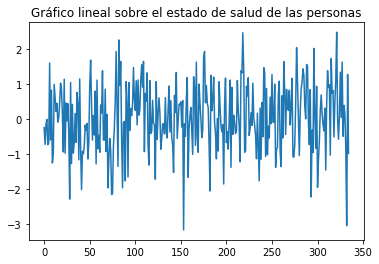

In [ ]:
y = np.random.randn(len(nutrientes))
x = [x for x in range(len(nutrientes))]
plt.plot(x, y, '-')
plt.fill_between(x, y, 200, where = (y> 195), facecolor = 'g', alpha = 0.6)
plt.title( "Gráfico lineal sobre el estado de salud de las personas")
plt.show()